In [ ]:
# くずし字 ターゲットを49 => 10、あ行と か行の10個で

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import lightgbm as lgb

from sklearn.metrics import confusion_matrix, accuracy_score


In [2]:
cl_map = pd.read_csv('./dataset/kuzushiji/k49_classmap.csv')

In [3]:
cl_map.shape

(49, 3)

In [4]:
print(cl_map.shape)

(49, 3)


In [8]:
# 10個だけ、あ行とか行だけ
cl_map_s = cl_map[cl_map['index'] <= 9]

In [9]:
cl_map_s

,index,codepoint,char
0,0,U+3042,あ
1,1,U+3044,い
2,2,U+3046,う
3,3,U+3048,え
4,4,U+304A,お
5,5,U+304B,か
6,6,U+304D,き
7,7,U+304F,く
8,8,U+3051,け
9,9,U+3053,こ


In [10]:
# 訓練データの読み込み
X_train = np.load('./dataset/kuzushiji/k49-train-imgs.npz')['arr_0']
y_train = np.load('./dataset/kuzushiji/k49-train-labels.npz')['arr_0']

In [11]:
# テストデータの読み込み
X_test = np.load('./dataset/kuzushiji/k49-test-imgs.npz')['arr_0']
y_test = np.load('./dataset/kuzushiji/k49-test-labels.npz')['arr_0']

In [12]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((232365, 28, 28), (232365,), (38547, 28, 28), (38547,))

In [17]:
X_train = X_train.reshape(X_train.shape[0], -1)
y_train = y_train.reshape(y_train.shape[0], -1)
print(X_train.shape)
print(y_train.shape)

(232365, 784)
(232365, 1)


In [19]:
# 結合
train_d = np.hstack((y_train, X_train.reshape(X_train.shape[0], -1)))

In [20]:
# あ行とか行だけにする
train_d = train_d[train_d[:, 0] <= 9]

In [21]:
train_d.shape

(53491, 785)

In [22]:
np.max(train_d[:, 0])

9

In [23]:
# 特徴量とターゲットに分離
X_train_d = train_d[:, 1:]
y_train_d = train_d[:, 0]

In [24]:
X_test = X_test.reshape(X_test.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)
print(X_test.shape)
print(y_test.shape)

(38547, 784)
(38547, 1)


In [27]:
# 結合
test_d = np.hstack((y_test, X_test.reshape(X_test.shape[0], -1)))

In [28]:
# あ行とか行だけにする
test_d = test_d[test_d[:, 0] <= 9]

In [29]:
test_d.shape

(8893, 785)

In [30]:
np.max(test_d[:, 0])

9

In [31]:
# 特徴量とターゲットに分離
X_test_d = test_d[:, 1:]
y_test_d = test_d[:, 0]

In [32]:
cl_map_np = np.array(cl_map_s)

In [33]:
#cl_map_np[[y_train[:5]], :]
cl_map_np

array([[0, 'U+3042', 'あ'],
       [1, 'U+3044', 'い'],
       [2, 'U+3046', 'う'],
       [3, 'U+3048', 'え'],
       [4, 'U+304A', 'お'],
       [5, 'U+304B', 'か'],
       [6, 'U+304D', 'き'],
       [7, 'U+304F', 'く'],
       [8, 'U+3051', 'け'],
       [9, 'U+3053', 'こ']], dtype=object)

In [34]:
cl_map_index = cl_map_s.set_index('index').to_dict()['char']

In [35]:
cl_map_index

{0: 'あ',
 1: 'い',
 2: 'う',
 3: 'え',
 4: 'お',
 5: 'か',
 6: 'き',
 7: 'く',
 8: 'け',
 9: 'こ'}

In [38]:
X_train_d.min(), X_train_d.max()

(0, 255)

In [39]:
y_train_d[423]

2

In [40]:
cl_map_np[[y_train_d[100]], :]

array([[9, 'U+3053', 'こ']], dtype=object)

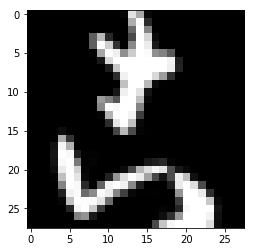

In [42]:
plt.imshow(X_train_d[100].reshape(28, 28), cmap=plt.cm.gray)
plt.show()

In [45]:
X_train_d = X_train_d.reshape(X_train_d.shape[0], 28, 28)
X_test_d = X_test_d.reshape(X_test_d.shape[0], 28, 28)

In [46]:
X_train_d[0, 10:15, 10:15]

array([[ 63, 238, 255, 255, 192],
       [120, 255, 239, 195,  29],
       [168, 255, 131,  12,   0],
       [ 83, 253, 135,   0,   0],
       [126, 225, 106,   0,   0]], dtype=uint8)

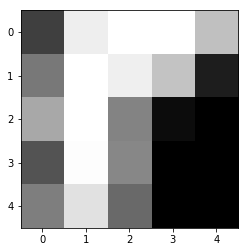

In [47]:
plt.imshow(X_train_d[0, 10:15, 10:15], cmap=plt.cm.gray)

In [48]:
cl_map_index[0]

'あ'

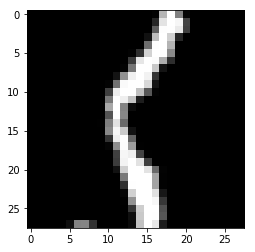

In [50]:
plt.imshow(X_train_d[0], cmap=plt.cm.gray)

In [55]:
y_train_d[0]

7

In [56]:
cl_map_index[y_train_d[0]]

'く'

In [57]:
# 正規化
X_train_n = X_train_d / 255
X_test_n = X_test_d / 255

In [58]:
X_train_d[0, 10:15, 10:15]

array([[ 63, 238, 255, 255, 192],
       [120, 255, 239, 195,  29],
       [168, 255, 131,  12,   0],
       [ 83, 253, 135,   0,   0],
       [126, 225, 106,   0,   0]], dtype=uint8)

In [59]:
X_train_n[0, 10:15, 10:15]

array([[0.24705882, 0.93333333, 1.        , 1.        , 0.75294118],
       [0.47058824, 1.        , 0.9372549 , 0.76470588, 0.11372549],
       [0.65882353, 1.        , 0.51372549, 0.04705882, 0.        ],
       [0.3254902 , 0.99215686, 0.52941176, 0.        , 0.        ],
       [0.49411765, 0.88235294, 0.41568627, 0.        , 0.        ]])

In [60]:
X_train_n = X_train_n.reshape(X_train_n.shape[0], -1)
X_test_n = X_test_n.reshape(X_test_n.shape[0], -1)

In [61]:
X_train_n.shape, X_test_n.shape

((53491, 784), (8893, 784))

In [62]:
lgb.LGBMClassifier()

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [63]:
# LightGBMのモデルへデータセットの初期化セット
train_data = lgb.Dataset(X_train_n, label=y_train_d)
test_data =  lgb.Dataset(X_test_n, label=y_test_d, reference=train_data)

In [64]:
# パラメータ
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 10,
    'verbose': 2
}

In [65]:
# 訓練
gbm = lgb.train(
    params,
    train_data,
    valid_sets=test_data,
    num_boost_round=100,
    verbose_eval=5,
)


[5]	valid_0's multi_logloss: 1.50469
[10]	valid_0's multi_logloss: 1.15467
[15]	valid_0's multi_logloss: 0.936698
[20]	valid_0's multi_logloss: 0.788248
[25]	valid_0's multi_logloss: 0.681911
[30]	valid_0's multi_logloss: 0.604417
[35]	valid_0's multi_logloss: 0.545378
[40]	valid_0's multi_logloss: 0.498944
[45]	valid_0's multi_logloss: 0.461907
[50]	valid_0's multi_logloss: 0.431632
[55]	valid_0's multi_logloss: 0.406564
[60]	valid_0's multi_logloss: 0.385135
[65]	valid_0's multi_logloss: 0.366078
[70]	valid_0's multi_logloss: 0.350102
[75]	valid_0's multi_logloss: 0.336041
[80]	valid_0's multi_logloss: 0.323476
[85]	valid_0's multi_logloss: 0.312959
[90]	valid_0's multi_logloss: 0.302852
[95]	valid_0's multi_logloss: 0.294074
[100]	valid_0's multi_logloss: 0.286072


In [66]:
preds = gbm.predict(X_test_n)

In [67]:
preds.shape

(8893, 10)

In [68]:
y_pred = np.argmax(preds, axis=1)

In [69]:
y_pred.shape

(8893,)

In [71]:
confusion_matrix(y_test_d, y_pred)

array([[922,  13,   0,   0,   5,  10,  16,   8,  24,   2],
       [  1, 963,   0,   0,   7,   5,   1,   2,  20,   1],
       [  0,   0, 960,   0,   0,  29,   4,   2,   2,   3],
       [  0,   0,   2, 114,   1,   0,   1,   4,   0,   4],
       [ 18,  15,   0,   0, 906,  25,  11,   2,  21,   2],
       [ 19,   5,  39,   1,  18, 878,   7,   5,  12,  16],
       [  5,   0,   6,   0,   3,   7, 921,   1,  35,  22],
       [  1,   0,   4,   4,   4,  10,   6, 934,   5,  32],
       [  9,   5,  10,   0,  11,  18,  36,   8, 653,  17],
       [ 37,   2,  20,   3,  13,  22,  18,  26,   8, 851]], dtype=int64)

In [72]:
accuracy_score(y_test_d, y_pred)

0.9110536376925672